### Derive Chemistry
- Project: DSA103 derive annotation chemistry from R script
- Author: Julian Stoerr
- Date: 30 November 2025

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from rdkit.Chem import Descriptors

Load data and inspect head

In [3]:
tropical_df = pd.read_csv("../data/mtbs_tropical_annotations.tsv",sep="\t")
tropical_df.head(3)

,feature_id,component_id,libname,structure_inchikey,structure_smiles,structure_molecular_formula,structure_taxonomy_npclassifier_01pathway,structure_taxonomy_npclassifier_02superclass,structure_taxonomy_npclassifier_03class
0,64000,2173,MS1_match,SRBFZHDQGSBBOR-HWQSCIPKSA-N,OC1OC[C@H](O)[C@H](O)[C@H]1O,C5H10O5,Carbohydrates,Saccharides,Monosaccharides
1,64000,2173,MS1_match,PYMYPHUHKUWMLA-WDCZJNDASA-N,O=C[C@@H](O)[C@H](O)[C@H](O)CO,C5H10O5,Carbohydrates,Saccharides,Monosaccharides
2,63994,2138,MS1_match,GLDOVTGHNKAZLK-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCO,C18H38O,Fatty acids,Fatty acyls,Fatty alcohols


Create mask for is smiles ok

In [49]:
mask = (
    tropical_df["structure_smiles"].notna() & 
    tropical_df["structure_smiles"].ne("") 

)

compounds_ok = tropical_df[mask]



In [5]:
compounds_ok.groupby("structure_smiles")

In [6]:
def most_common(series):
    counts = series.value_counts(dropna=True)
    if len(counts) == 0:
        return None
    else:
        return counts.idxmax()

In [7]:
compReady = (
    compounds_ok
    .groupby("structure_smiles")["structure_taxonomy_npclassifier_01pathway"]
    .agg(most_common)
    .reset_index()
)


In [8]:
print(compReady.shape)
compReady.head(5)


(24046, 2)


,structure_smiles,structure_taxonomy_npclassifier_01pathway
0,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids
1,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids
2,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids
3,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids
4,C#CC#CC=CC=CC=CCCO,Fatty acids


In [9]:
compReady["SID"] = "S" + (compReady.index + 1).astype(str)

In [10]:
compReady.head(5)

,structure_smiles,structure_taxonomy_npclassifier_01pathway,SID
0,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,S1
1,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,S2
2,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,S3
3,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,S4
4,C#CC#CC=CC=CC=CCCO,Fatty acids,S5


In [11]:
#do not use these descriptors:   redundant <- c(2, 7, 8, 11, 15, 17, 18, 20, 21, 24, 29, 33:38, 41, 43:45)

redundant = (
    [2, 7, 8, 11, 15, 17, 18, 20, 21, 24, 29] +
    list(range(33, 39)) +
    [41] +
    list(range(43, 46))
)
redundant = [i - 1 for i in redundant]

all_desc = list(Descriptors.descList)

desc_used = []

for id, name in enumerate(all_desc):
    if id not in redundant:
        desc_used.append(name)
print(desc_used)



[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x000002BEC3EEED40>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x000002BEC3EEEDE0>), ('MinEStateIndex', <function MinEStateIndex at 0x000002BEC3EEECA0>), ('qed', <function qed at 0x000002BEC3F25DA0>), ('SPS', <function SPS at 0x000002BEC3F26340>), ('ExactMolWt', <function <lambda> at 0x000002BEC3F26B60>), ('NumValenceElectrons', <function NumValenceElectrons at 0x000002BEC3F26C00>), ('MaxPartialCharge', <function MaxPartialCharge at 0x000002BEC3F26DE0>), ('MinPartialCharge', <function MinPartialCharge at 0x000002BEC3F26E80>), ('MaxAbsPartialCharge', <function MaxAbsPartialCharge at 0x000002BEC3F26F20>), ('FpDensityMorgan1', <function FpDensityMorgan1 at 0x000002BEC3F271A0>), ('BCUT2D_MWHI', <function BCUT2D_MWHI at 0x000002BEC3F27380>), ('BCUT2D_CHGLO', <function BCUT2D_CHGLO at 0x000002BEC3F27560>), ('BCUT2D_LOGPHI', <function BCUT2D_LOGPHI at 0x000002BEC3F27600>), ('BCUT2D_MRHI', <function BCUT2D_MRHI at 0x000002BEC3F2

In [12]:
from rdkit import Chem
compReady["mol"] = compReady["structure_smiles"].apply(Chem.MolFromSmiles)

In [13]:
rows = []

for mol in compReady["mol"]:
    row = {}
    for name, func in desc_used:
        row[name] = func(mol)

    rows.append(row)

desc_df = pd.DataFrame(rows)
#desc_df.head(5)



In [42]:
compOut = pd.concat(
    [compReady.reset_index(drop=True), desc_df],
    axis=1
)
print(compOut.shape)
compOut.head(20)


(24046, 200)


,structure_smiles,structure_taxonomy_npclassifier_01pathway,SID,mol,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,S1,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,5.138392,0.937871,0.937871,0.332032,10.636364,292.219101,...,0,0,0,2,0,0,0,0,8,0
1,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,S2,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,5.223961,0.943318,0.943318,0.309396,9.809524,282.234751,...,0,0,0,2,0,0,0,0,11,0
2,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,S3,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,8.490439,0.043231,-0.043231,0.492037,9.043478,308.214016,...,0,0,0,1,0,0,0,0,8,0
3,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,S4,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,11.886906,0.190474,0.190474,0.285907,14.772727,297.209264,...,0,0,0,1,0,0,0,0,4,0
4,C#CC#CC=CC=CC=CCCO,Fatty acids,S5,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,8.439692,0.188318,0.188318,0.504961,10.461538,172.088815,...,0,0,0,1,0,0,0,0,0,0
5,C#CC#CCC/C=C/C=C/C(=O)N1CCCCC1,Alkaloids,S6,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,11.732872,0.117105,0.117105,0.320427,15.388889,241.146664,...,0,0,0,1,0,0,0,0,1,0
6,C#CC#CCC/C=C/C=C/C(O)=NCC(C)C,Fatty acids,S7,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,9.355535,0.065253,0.065253,0.245050,11.764706,229.146664,...,0,0,0,1,0,0,0,0,1,0
7,C#CC#CCC/C=C/C=C\C(O)=NCCc1ccccc1,Polyketides,S8,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,9.584664,0.044171,0.044171,0.266053,11.285714,277.146664,...,0,0,0,1,0,0,0,0,1,0
8,C#CC#CCC=CCCCCCC(C)=O,Fatty acids,S9,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,10.633999,0.287131,0.287131,0.352019,9.333333,202.135765,...,0,0,0,1,0,0,0,0,3,0
9,C#CC12OC1(C=O)C1C(O)CC3C(C)(C)CCCC3(C)C1CC2=O,Terpenoids,S10,<rdkit.Chem.rdchem.Mol object at 0x000002BEC54...,12.784456,0.048611,-1.426312,0.454288,54.708333,330.183109,...,0,0,0,1,0,0,0,0,0,0


In [62]:
#for col in compOut.columns:
#    print(f"{col}: {compOut[col].nunique()}")

### PCA

[32.86522132 19.25864491]


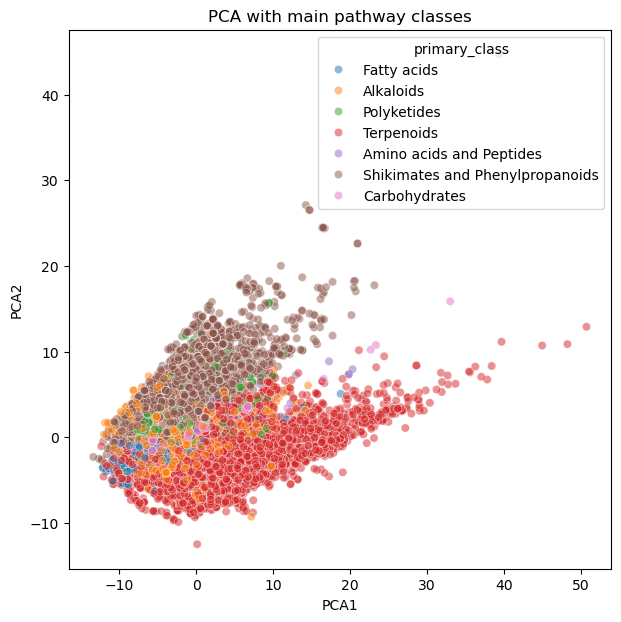

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

compOut_num = compOut.copy().select_dtypes("number")
#compOut_num.head(5)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(compOut_num)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(pca.explained_variance_) #-> PCA1 explains 33% of variance and PCA2 19%

pca_df = pd.DataFrame(X_pca,columns=["PCA1","PCA2"])
pca_df["structure_taxonomy_npclassifier_01pathway"] = compOut["structure_taxonomy_npclassifier_01pathway"]
pca_df["primary_class"] = pca_df["structure_taxonomy_npclassifier_01pathway"].str.split("|").str[0]

plt.figure(figsize=[7,7])
sns.scatterplot(data=pca_df,x="PCA1",y="PCA2",hue="primary_class",alpha=0.5)
#plt.legend().remove()
plt.title("PCA with main pathway classes")
plt.show()



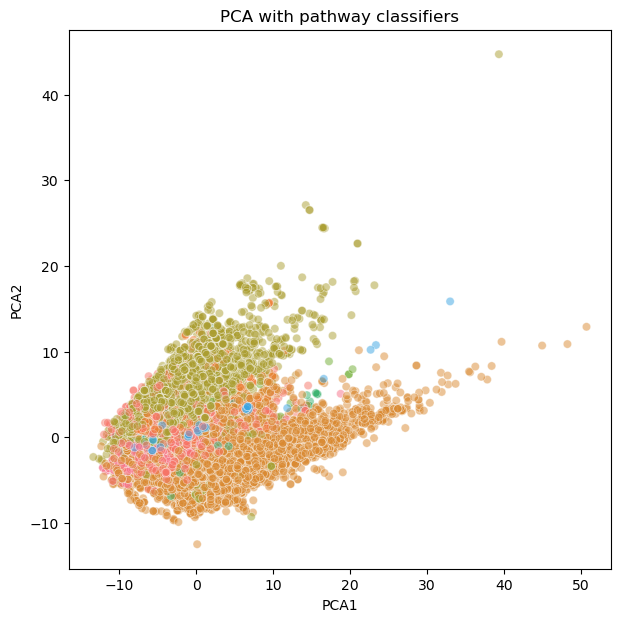

In [65]:
plt.figure(figsize=[7,7])
sns.scatterplot(data=pca_df,x="PCA1",y="PCA2",hue="structure_taxonomy_npclassifier_01pathway",alpha=0.5)
plt.legend().remove()
plt.title("PCA with pathway classifiers")
plt.show()